# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files

In [ ]:
file1 = files.upload()

Saving lfw_dataset.py to lfw_dataset.py


In [ ]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

In [ ]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


In [ ]:
data[:10000].shape

(10000, 45, 45, 3)

For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [ ]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

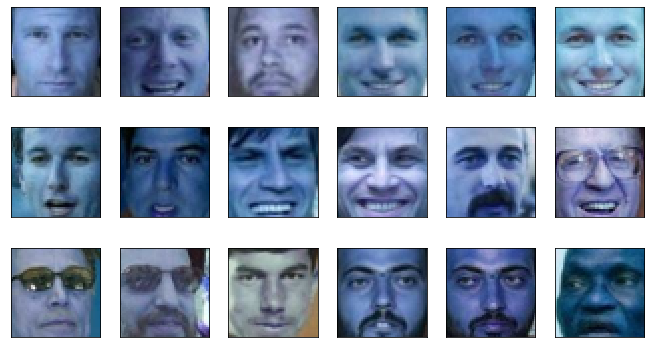

In [ ]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras import layers 
from keras.layers import Lambda
from keras import initializers
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam, SGD, Adamax,Adadelta


In [ ]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

inp = layers .Input(X_train.shape[1:])

encoder=Sequential()
encoder.add(layers .InputLayer(input_shape=X_train.shape[1:]))
encoder.add(layers .Dense(1024,activation='relu',   kernel_initializer='glorot_uniform',bias_initializer='zeros'))
encoder.add(layers .Dense(dimZ,kernel_initializer='glorot_uniform',bias_initializer='zeros'))

decoder=Sequential()
decoder.add(layers .InputLayer(input_shape=dimZ))
decoder.add(layers .Dense(1024,activation='relu',   kernel_initializer='glorot_uniform',bias_initializer='zeros'))
decoder.add(layers .Dense(6075,activation='sigmoid',kernel_initializer='glorot_uniform',bias_initializer='zeros'))

en = encoder(inp)
reconstruction = decoder(en)

autoencoder = Model(inp,reconstruction)

autoencoder.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse',metrics=['accuracy'])

autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6075)]            0         
_________________________________________________________________
sequential (Sequential)      (None, 100)               6324324   
_________________________________________________________________
sequential_1 (Sequential)    (None, 6075)              6330299   
Total params: 12,654,623
Trainable params: 12,654,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train.shape, X_val.shape

((10000, 6075), (3143, 6075))

In [ ]:
# Create MSE loss function

# Use Adam optimizer

In [ ]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
from keras import backend as K
K.clear_session()

history = autoencoder.fit(X_train, X_train, epochs=40, verbose=1, batch_size=35,
                validation_data=(X_val, X_val))

Epoch 1/40
286/286 [==============================] - 3s 8ms/step - loss: 0.0221 - accuracy: 0.0029 - val_loss: 0.0133 - val_accuracy: 0.0035
Epoch 2/40
286/286 [==============================] - 2s 7ms/step - loss: 0.0116 - accuracy: 0.0074 - val_loss: 0.0103 - val_accuracy: 0.0083
Epoch 3/40
286/286 [==============================] - 2s 7ms/step - loss: 0.0088 - accuracy: 0.0085 - val_loss: 0.0072 - val_accuracy: 0.0165
Epoch 4/40
286/286 [==============================] - 2s 7ms/step - loss: 0.0068 - accuracy: 0.0093 - val_loss: 0.0061 - val_accuracy: 0.0143
Epoch 5/40
286/286 [==============================] - 2s 7ms/step - loss: 0.0058 - accuracy: 0.0157 - val_loss: 0.0060 - val_accuracy: 0.0172
Epoch 6/40
286/286 [==============================] - 2s 7ms/step - loss: 0.0054 - accuracy: 0.0182 - val_loss: 0.0051 - val_accuracy: 0.0150
Epoch 7/40
286/286 [==============================] - 2s 7ms/step - loss: 0.0051 - accuracy: 0.0171 - val_loss: 0.0051 - val_accuracy: 0.0159
Epoch 

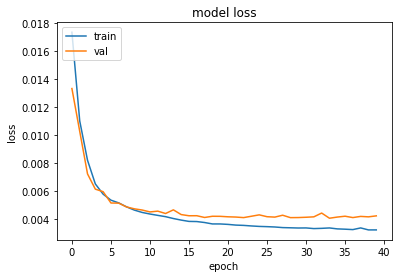

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import random

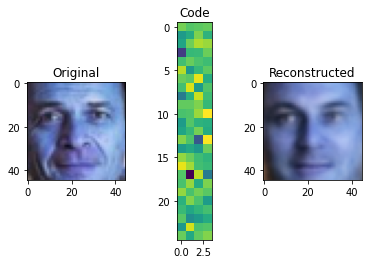

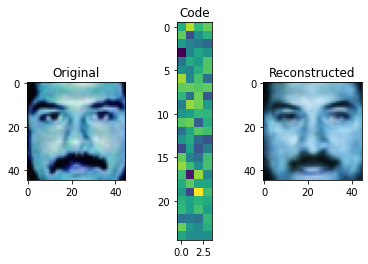

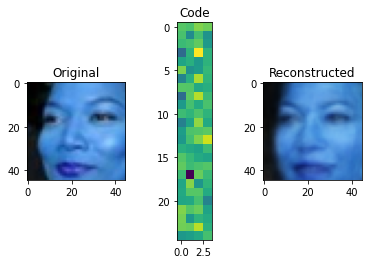

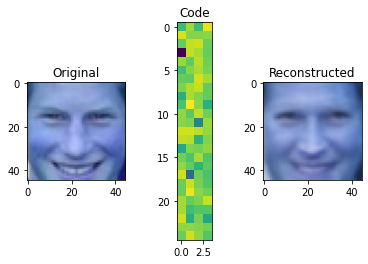

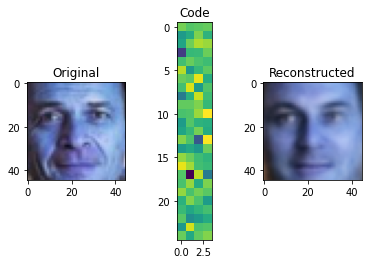

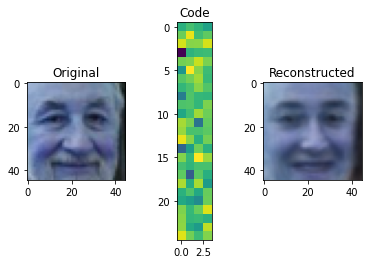

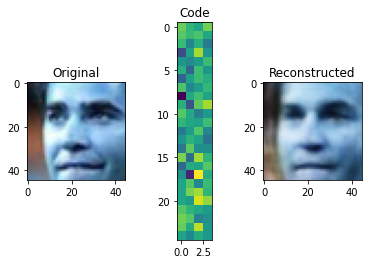

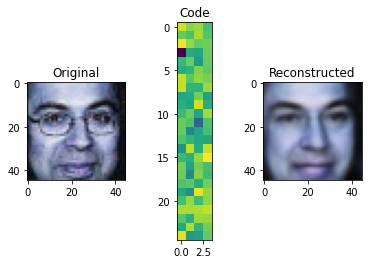

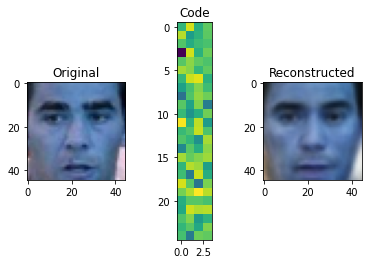

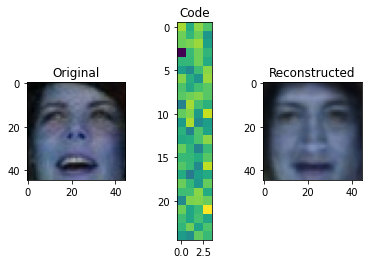

In [ ]:
# Examine the reconstructions

for _ in range(10):
  i=random.randint(1,300)
  x=X_val[i].reshape(1,-1)
  code = encoder.predict(x)
  reco = decoder.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(X_val[i].reshape((h, w, 3)))

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//4,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(reco.reshape((h, w, 3)))
  plt.show()

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

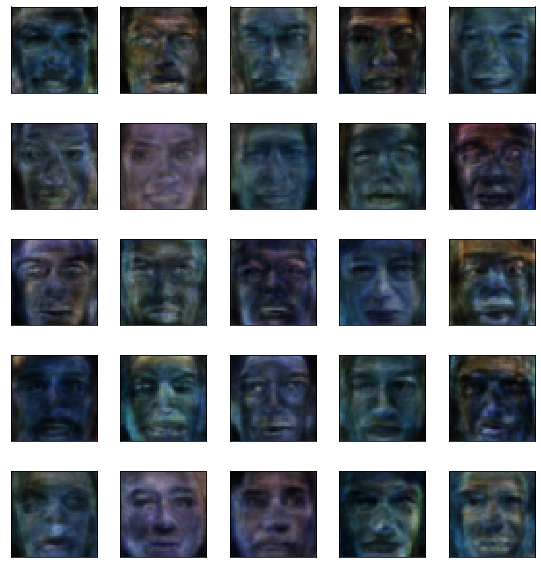

In [ ]:
z = np.random.randn(25, dimZ)*0.5
output = decoder.predict(z[None])[0] # FIXME compute from decoder from z
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [ ]:
original_dim=X_train.shape[1]
input_shape = (original_dim,)

In [ ]:
def sampling(args):
    mu, logsigma = args
    batch = K.shape(mu)[0]
    dim  = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    random_sample = mu + K.exp(0.5*logsigma) * epsilon
    return random_sample

In [ ]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST


##### Encoder #####
inp = layers .Input(input_shape)
x=layers .Dense(1024,activation='relu',kernel_initializer='glorot_uniform',bias_initializer='zeros')(inp)
mu=layers .Dense(dimZ, name='e_mu',kernel_initializer='glorot_uniform',bias_initializer='zeros') (x)
logsigma=layers .Dense(dimZ,name='e_logsigma',kernel_initializer='glorot_uniform',bias_initializer='zeros')(x)

z = Lambda(sampling, output_shape=(dimZ, ), name='z')([mu, logsigma])

encoder = Model(inp, [mu, logsigma, z], name='encoder')
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6075)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         6221824     input_1[0][0]                    
__________________________________________________________________________________________________
e_mu (Dense)                    (None, 100)          102500      dense[0][0]                      
__________________________________________________________________________________________________
e_logsigma (Dense)              (None, 100)          102500      dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
##### dencoder #####
inp_d = layers .Input(shape=(dimZ, ))
x=layers .Dense(1024,activation='relu',kernel_initializer='glorot_uniform',bias_initializer='zeros') (inp_d)
d_mu=layers .Dense(6075, name='dec_mu',kernel_initializer='glorot_uniform',bias_initializer='zeros',activation='sigmoid') (x)
d_logsigma=layers .Dense(6075,name='dec_logsigma',kernel_initializer='glorot_uniform',bias_initializer='zeros',activation='sigmoid')(x)

out_normal = Lambda(sampling, output_shape=(6075, ), name='out_z')([d_mu, d_logsigma])

out=layers .Activation('sigmoid')(out_normal)

decoder = Model(inp_d, [d_mu,d_logsigma,out], name='decoder')
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         103424      input_2[0][0]                    
__________________________________________________________________________________________________
dec_mu (Dense)                  (None, 6075)         6226875     dense_1[0][0]                    
__________________________________________________________________________________________________
dec_logsigma (Dense)            (None, 6075)         6226875     dense_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
batch_size = 25
epochs = 225

In [ ]:
d_mu, d_logsigma,out=decoder(encoder(inp)[2])
vae = Model(inp, out, name='vae_c')
vae.summary()

Model: "vae_c"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6075)]            0         
_________________________________________________________________
encoder (Functional)         [(None, 100), (None, 100) 6426824   
_________________________________________________________________
decoder (Functional)         [(None, 6075), (None, 607 12557174  
Total params: 18,983,998
Trainable params: 18,983,998
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

In [ ]:
def KL_divergence(mu, logsigma):
    kl_loss = -0.5 * (1 + logsigma - tf.square(mu) - tf.exp(logsigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return kl_loss

def log_likelihood(x, mu, logsigma):
    x_prec = tf.exp(logsigma)
    x_diff = x - mu
    x_power = -0.5 * tf.square(x_diff) * x_prec
    return -0.5 * (logsigma + np.log(2 * np.pi)) + x_power

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):    
    return KL_divergence(mu_z,logsigma_z)-log_likelihood(x, mu_gen, logsigma_gen)

In [ ]:
# # reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inp, out)
# # reconstruction_loss =tf.reduce_sum(inputs * tf.math.log(outputs))
# # reconstruction_loss=objectives.binary_crossentropy(inputs, outputs)
# reconstruction_loss *= original_dim
# kl_loss = K.square(mu)+K.exp(logsigma) - logsigma -1 
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= 0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)

kl_loss =  (1 + logsigma - tf.square(mu) - tf.exp(logsigma))
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=1)

x_prec = tf.exp(d_logsigma)
x_diff = inp - d_mu 
log_like=tf.reduce_sum(-d_logsigma-0.5 * tf.square(x_diff) / x_prec)

vae_loss = kl_loss-log_like

# vae_loss=loss_vae(inp,d_mu,d_logsigma,mu,logsigma)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.0001))



In [ ]:
history=vae.fit(X_train,X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, X_val))

Epoch 1/225
400/400 [==============================] - 4s 8ms/step - loss: 14152.9581 - val_loss: 1809.2826
Epoch 2/225
400/400 [==============================] - 3s 7ms/step - loss: 1646.8901 - val_loss: 1385.8398
Epoch 3/225
400/400 [==============================] - 3s 7ms/step - loss: 1349.9301 - val_loss: 1230.8795
Epoch 4/225
400/400 [==============================] - 3s 7ms/step - loss: 1160.5459 - val_loss: 1064.5226
Epoch 5/225
400/400 [==============================] - 3s 7ms/step - loss: 1036.4761 - val_loss: 956.8511
Epoch 6/225
400/400 [==============================] - 3s 7ms/step - loss: 956.6313 - val_loss: 897.0894
Epoch 7/225
400/400 [==============================] - 3s 7ms/step - loss: 894.3676 - val_loss: 838.2817
Epoch 8/225
400/400 [==============================] - 3s 7ms/step - loss: 839.9658 - val_loss: 793.6476
Epoch 9/225
400/400 [==============================] - 3s 7ms/step - loss: 790.0935 - val_loss: 750.9240
Epoch 10/225
400/400 [=======================

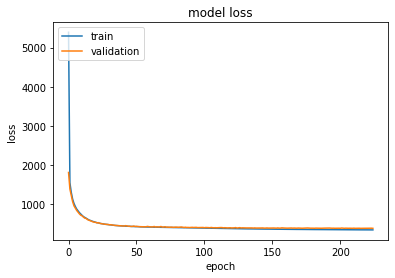

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [ ]:
# test your autoencoder with validation data

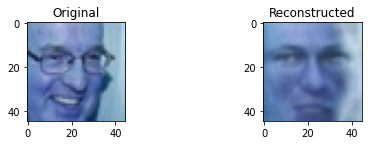

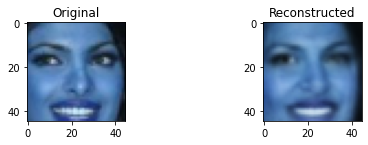

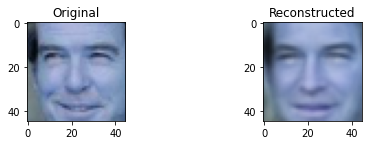

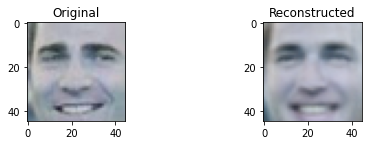

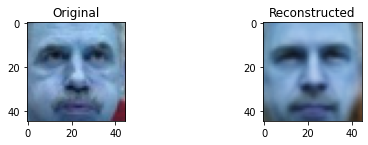

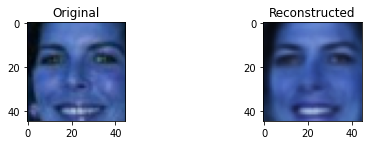

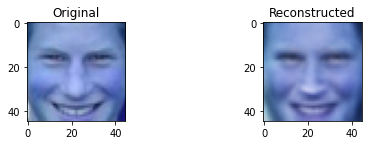

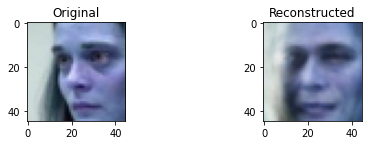

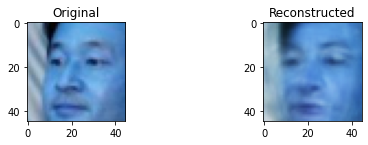

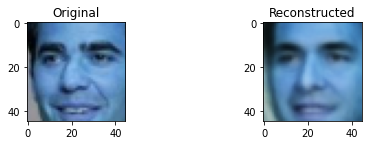

In [ ]:

for _ in range(10):
  i=random.randint(1,300)
  
  code = encoder(X_val[i].reshape(1,-1))

  reco = decoder(code[2])[0]

  k=X_val[i].reshape((data.shape[1], data.shape[2], 3))

  plt.subplot(1,3,1)
  plt.title("Original")
  plt.imshow(X_val[i].reshape((data.shape[1], data.shape[2], 3)))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  plt.imshow(tf.reshape(reco,shape=((data.shape[1], data.shape[2], 3))))
  plt.show()

In [ ]:
 decoder(code[1])

[<tf.Tensor: shape=(1, 6075), dtype=float32, numpy=
 array([[0.9907128 , 0.99374217, 0.99930143, ..., 0.9999236 , 0.99979085,
         0.9998734 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6075), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6075), dtype=float32, numpy=
 array([[0.25954595, 0.53428686, 0.3945241 , ..., 0.69335103, 0.98504364,
         0.73010975]], dtype=float32)>]

And train the model:

And finally sample from VAE.

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = sampling([mu, logsigma])
dec=decoder(z)
dec_sample=sampling([dec[0], dec[1]])

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [ ]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [ ]:
smile = attrs['Smiling'].sort_values(ascending=False).iloc[:10].index
no_smile= attrs['Smiling'].sort_values(ascending=True).iloc[:10].index

smile_points = data[smile]
no_smile_points= data[no_smile]

smile_points = np.float32(smile_points)
smile_points = smile_points/255

no_smile_points = np.float32(no_smile_points)
no_smile_points= no_smile_points/255

smile_data=np.concatenate((smile_points, no_smile_points), axis=0)

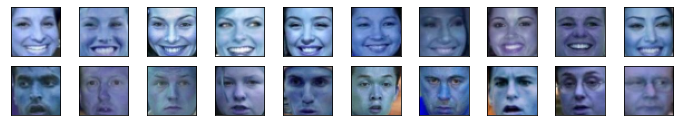

In [ ]:
plt.figure(figsize=(2 * 6,  1*2))
# plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(2 * 10):
    plt.subplot(2, 10, i + 1)
        
    plt.imshow(sm_date[i], cmap=plt.cm.gray, vmin=-1, vmax=1)
           
    plt.xticks(())
    plt.yticks(())


In [ ]:
smile_mean= tf.reduce_mean(encoder(smile_points .reshape((-1,6075))), axis=0)[0]
no_smile_mean = tf.reduce_mean(encoder(no_smile_points .reshape((-1,6075))), axis=0)[0]
vector_smile = smile_mean - no_smile_mean

In [ ]:
mu= encoder(no_smile_points [0].reshape((-1,6075)))[0]
mu += vector_smile
output = decoder(mu)[0]

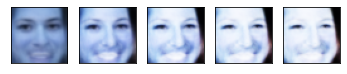

In [ ]:
plt.figure(figsize=(2 * 6,  1*2))
origin=no_smile_points [0].reshape((-1,6075))

for i in range(5):
  mu= encoder(origin)[0]
  mu += vector_smile
  origin = decoder(mu)[0]

  plt.subplot(1, 10, i+1)

  plt.imshow(tf.reshape(origin,[45,45,3]), cmap=plt.cm.gray, vmin=-1, vmax=1)

  plt.xticks(())
  plt.yticks(())
